# Counterfactual Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from dice_ml import Data, Model, Dice
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

In [2]:
model_df = pd.read_csv("not_scaling.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0,80.0,25.19,6.6,140
1,0,0,0,0,0,1,54.0,27.32,6.6,80
2,0,0,0,0,1,0,28.0,27.32,5.7,158
3,0,0,0,0,0,2,36.0,23.45,5.0,155
4,1,1,0,0,1,2,76.0,20.14,4.8,155


In [3]:
# Define features (X) and target (y)
X = model_df.drop(["diabetes"],axis=1)
y = model_df[["diabetes"]]

In [4]:
# Split data into training and test sets
X_train_, X_test, y_train_, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

In [5]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_, y_train_)
len(y_train), len(y_test),len(X_train), len(X_test)
y_train = y_train.values.ravel() 

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [6]:
best_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    max_features="sqrt"
)

best_rf.fit(X_train, y_train)  

RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_estimators=500,
                       random_state=42)

In [7]:
model_df["blood_glucose_level"] = model_df["blood_glucose_level"].astype(float)
data_dice = Data(
    dataframe=model_df,
    continuous_features=["age", "bmi", "HbA1c_level", "blood_glucose_level"],
    categorical_features=["gender", "hypertension", "heart_disease", "smoking_history"],
    outcome_name="diabetes"
)

In [8]:
model_dice = Model(model=best_rf, backend="sklearn")

In [9]:
explainer = Dice(
    data_dice,
    model_dice,
    method="genetic"
)

In [10]:
diff_stats = []

for i in range(30):
    query_instance = X_test.iloc[i:i+1]
    dice_exp = explainer.generate_counterfactuals(
        query_instance,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=["HbA1c_level","blood_glucose_level","bmi","smoking_history","hypertension",
                          "heart_disease","age","gender"]
    )
    df = dice_exp.cf_examples_list[0].final_cfs_df
    dice_exp.visualize_as_dataframe()

    for j in range(len(df)):
        diff_features = []
        for col in [ "bmi", "HbA1c_level", "blood_glucose_level", "smoking_history",  "hypertension",
                     "heart_disease","age","gender"]:
            if not np.isclose(query_instance[col].values[0], df[col].iloc[j]):
                diff_features.append(col)

        diff_stats.append({
            "instance": i,
            "cf": j + 1,
            "changed_features": diff_features
        })

diff_stats_filtered = [stat for stat in diff_stats if len(stat['changed_features']) > 0]
pd.DataFrame(diff_stats_filtered)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,1,50.0,27.32,4.8,140,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,1,55.0,48.0,4.0,252,1
0,0,1,0,1,1,53.0,62.0,7.0,140,1
0,1,1,0,1,1,16.0,80.0,4.0,299,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,1,36.0,27.32,5.7,100,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,1,19.0,21.0,4.0,245,1
0,0,1,0,0,1,31.0,24.0,4.0,218,1
0,1,0,0,0,1,7.0,25.0,8.0,91,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,21.0,27.32,5.8,126,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,1,1,40.0,12.0,6.0,236,1
0,1,0,0,1,2,23.0,41.0,7.0,110,1
0,1,1,0,0,0,1.0,77.0,8.0,291,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,49.0,41.970001,4.0,155,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,49.0,59.00,5.0,249,1
0,0,0,0,0,0,49.0,10.01,5.0,249,1
0,0,0,0,0,0,0.1,45.00,5.0,249,1


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,32.0,31.790001,5.8,85,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,0.1,10.01,5.0,270,1
0,0,0,0,0,0,52.0,10.01,5.0,270,1
0,0,0,0,0,1,52.0,10.01,5.0,270,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,31.0,27.32,5.8,200,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,31.0,40.0,5.8,200,1
0,1,0,0,0,2,67.0,21.0,8.0,186,1
0,0,1,0,1,2,80.0,95.0,5.0,261,1


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.35s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,22.0,29.73,4.8,155,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,1,0,1,2,25.0,16.0,8.0,149,1
0,1,1,0,0,1,31.0,25.0,9.0,81,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.95s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,80.0,25.15,4.8,85,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,46.0,10.01,5.0,259,1
0,0,1,0,0,1,1.0,87.00,4.8,281,1
0,0,0,0,0,2,46.0,89.00,5.0,268,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,1,21.0,36.490002,6.0,140,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,0,0,33.0,66.0,6.0,294,1
0,0,0,0,1,1,20.0,32.0,5.0,293,1
0,0,0,0,0,1,8.0,49.0,8.0,159,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,0,0,80.0,33.209999,5.7,155,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,0,0,80.0,80.0,5.7,155,1
0,0,0,0,0,0,80.0,53.0,5.7,155,1
0,1,1,0,0,0,80.0,79.0,5.7,155,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,28.0,22.16,5.7,158,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,1,1,37.0,24.0,7.0,296,1
0,1,1,0,0,2,41.0,17.0,5.0,257,1
0,1,1,0,1,1,45.0,58.0,7.0,232,1


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.00s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,80.0,22.030001,5.0,126,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,79.0,10.01,5.0,294,1
0,0,1,0,0,0,80.0,43.00,5.0,251,1
0,0,0,0,0,0,32.0,10.01,5.0,294,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,51.0,33.400002,5.7,126,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,51.0,48.0,5.7,126,1
0,0,0,0,0,0,51.0,49.0,5.7,126,1
0,0,0,0,0,0,51.0,50.0,5.7,126,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,38.0,29.290001,6.0,85,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,0,2,8.0,53.00,5.0,247,1
0,0,0,0,0,2,59.0,74.00,8.0,150,1
0,1,0,0,0,2,59.0,10.01,8.0,80,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,28.0,17.629999,5.8,160,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,1,0,61.0,58.0,7.0,238,1
0,1,1,0,1,1,49.0,74.0,5.0,245,1
0,0,1,0,1,1,12.0,79.0,4.0,297,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,40.0,30.77,5.7,160,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,1,0,0,2,21.0,21.0,7.0,181,1
0,0,1,0,1,2,21.0,46.0,7.0,118,1
0,1,0,0,0,1,33.0,89.0,5.0,264,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.95s/it]

Query instance (original outcome : 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,80.0,34.209999,6.1,300,1



Diverse Counterfactual set (new outcome: 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,0,0,80.0,36.00,6.1,80,0
0,0,0,0,0,1,0.1,10.01,6.1,80,0
0,0,1,0,0,1,0.1,36.00,6.1,80,0


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,1,64.0,27.32,5.8,145,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,64.0,63.0,5.8,145,1
0,0,0,0,0,0,64.0,64.0,5.8,145,1
0,0,0,0,0,0,64.0,65.0,5.8,145,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,2,33.0,30.34,6.6,80,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,44.0,16.0,7.0,80,1
0,1,1,0,0,0,24.0,85.0,7.0,208,1
0,1,0,0,1,1,36.0,26.0,8.0,222,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,64.0,28.389999,4.8,160,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,0.1,10.01,3.5,296,1
0,0,0,0,0,0,0.1,10.01,3.5,296,1
0,0,0,0,1,1,0.1,10.01,3.5,296,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,64.0,48.32,3.5,155,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,0,68.0,39.0,3.5,229,1
0,0,1,0,1,0,68.0,69.0,3.5,229,1
0,0,1,0,1,1,0.1,39.0,3.5,229,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,38.0,29.379999,5.7,159,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,0,0,1,0,23.0,26.0,7.0,130,1
0,0,0,0,0,2,70.0,52.0,6.0,236,1
0,0,0,0,1,1,43.0,66.0,7.0,125,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,1,45.0,30.379999,5.8,90,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,2.0,43.00,7.0,90,1
0,0,0,0,0,0,32.0,49.00,7.0,90,1
0,0,0,0,0,0,2.0,10.01,7.0,90,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,1,40.0,29.23,4.5,155,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,1,8.0,49.0,5.0,230,1
0,0,0,0,0,1,40.0,39.0,8.0,172,1
0,0,1,0,1,1,10.0,72.0,5.0,282,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,72.0,30.98,6.2,145,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,72.0,70.0,6.2,145,1
0,0,0,0,0,0,72.0,72.0,6.2,145,1
0,0,0,0,0,0,72.0,73.0,6.2,145,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,34.0,39.299999,4.0,159,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,0,0,0.1,38.0,4.0,291,1
0,0,0,0,1,0,32.0,28.0,4.0,278,1
0,0,0,0,0,1,0.1,52.0,4.0,291,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,1,27.0,27.32,6.5,90,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,2,44.0,11.0,7.0,129,1
0,1,0,0,1,0,70.0,31.0,8.0,132,1
0,1,1,0,1,1,60.0,32.0,5.0,294,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,60.0,21.690001,6.6,160,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,0,0,60.0,55.0,6.6,160,1
0,0,0,0,0,0,60.0,58.0,6.6,160,1
0,0,0,0,0,0,60.0,60.0,6.6,160,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,10.0,27.32,6.5,80,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,2,1.0,72.0,8.0,274,1
0,1,1,0,1,0,80.0,65.0,8.0,165,1
0,1,1,0,0,1,50.0,21.0,8.0,114,1


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.91s/it]

Query instance (original outcome : 0)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,0,1,0,9.0,21.9,6.0,200,0



Diverse Counterfactual set (new outcome: 1)


,hypertension,heart_disease,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,2,63.0,65.0,6.0,229,1
0,0,0,0,1,2,51.0,23.0,7.0,296,1
0,0,0,0,1,0,46.0,77.0,9.0,85,1


,instance,cf,changed_features
0,0,1,"[bmi, HbA1c_level, blood_glucose_level, heart_..."
1,0,2,"[bmi, HbA1c_level, heart_disease, age]"
2,0,3,"[bmi, HbA1c_level, blood_glucose_level, hypert..."
3,1,1,"[bmi, HbA1c_level, blood_glucose_level, heart_..."
4,1,2,"[bmi, HbA1c_level, blood_glucose_level, heart_..."
...,...,...,...
84,28,2,"[bmi, HbA1c_level, blood_glucose_level, hypert..."
85,28,3,"[bmi, HbA1c_level, blood_glucose_level, smokin..."
86,29,1,"[bmi, blood_glucose_level, smoking_history, he..."
87,29,2,"[bmi, HbA1c_level, blood_glucose_level, smokin..."


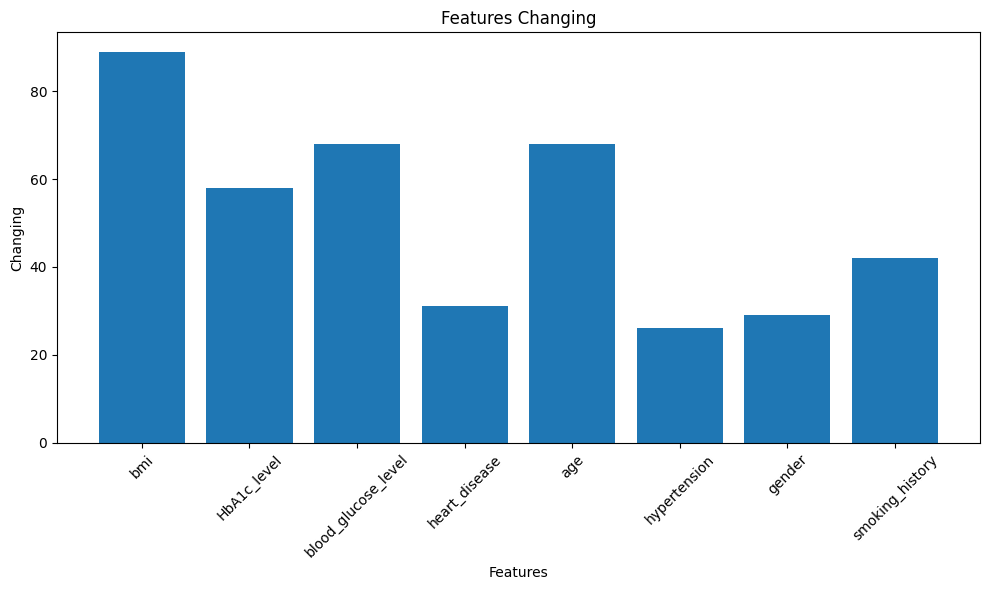

In [11]:
pd.DataFrame(diff_stats)
diff_df = pd.DataFrame(diff_stats)


all_changes = []
for changes in diff_df['changed_features']:
    all_changes.extend(changes)

change_counts = Counter(all_changes)

plt.figure(figsize=(10, 6))
plt.bar(change_counts.keys(), change_counts.values())
plt.title('Features Changing')
plt.xlabel('Features')
plt.ylabel('Changing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("feature_changes.png", dpi=300, bbox_inches="tight")
plt.show()